In [1]:
import torch
import numpy as np
from tqdm.auto import tqdm
from model import BendrEncoder

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from src.data.processing import load_data_dict, get_data
from src.data.conf.eeg_channel_picks import hackathon
from src.data.conf.eeg_channel_order import standard_19_channel
from src.data.conf.eeg_annotations import braincapture_annotations, tuh_eeg_artefact_annotations
from torch import nn
from model.model import Flatten

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
encoder = BendrEncoder()
encoder.load_state_dict(torch.load("encoder_2.pt"))
encoder = encoder.to(device)

In [3]:
# enc_augment = ["mask_replacement", "relative_position.0.bias", "relative_position.0.weight_g", "relative_position.0.weight_v", "input_conditioning.1.weight", "input_conditioning.1.bias", "input_conditioning.4.weight", "input_conditioning.4.bias"]
# checkpoint = torch.load("epoch=1-step=163.ckpt")['state_dict']

# encoder_state_dict = {}
# for k,v in checkpoint.items():
#     if k.startswith("encoder."):
#         encoder_state_dict[k[8:]] = v
#     elif k.replace("contextualizer.", "") in enc_augment:
#         encoder_state_dict[k.replace("contextualizer.", "enc_augment.")] = v
#     elif k.startswith("enc_augment."):
#         encoder_state_dict[k] = v
# torch.save(encoder_state_dict, 'encoder_2.pt')

In [4]:
BC_path = "/mnt/c/Users/anders/Downloads/Bhutan/"
TUAR_path = "/mnt/c/Users/anders/Downloads/hackathon 01/TUAR/01_tcp_ar/"

In [5]:
data_dict = load_data_dict(BC_path, braincapture_annotations, labels=True)
all_subjects = list(data_dict.keys())
X_BC, y_BC = get_data(data_dict, all_subjects)
X_BC = torch.Tensor(X_BC)
y_BC = torch.Tensor(y_BC)
#X_data = torch.load("/mnt/c/Users/anders/OneDriveDTU/Dokumenter/Hackathon/X_BC.pt")
#y_data = torch.load("/mnt/c/Users/anders/OneDriveDTU/Dokumenter/Hackathon/y_BC.pt").long()

# Load X_combined_downstream.npy as torch
#X_data = torch.from_numpy(np.load('X_combined_downstream.npy'))
#y_data = torch.from_numpy(np.load('y_combined_downstream.npy'))

  2%|▏         | 3/133 [00:03<02:40,  1.24s/it]

In [10]:
latent = np.empty((X_data.shape[0], 1536, 4))
batch_size = 4

for i in tqdm(range(0, X_data.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_data[i:i+batch_size]).cpu().detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

  0%|          | 0/208 [00:00<?, ?it/s]

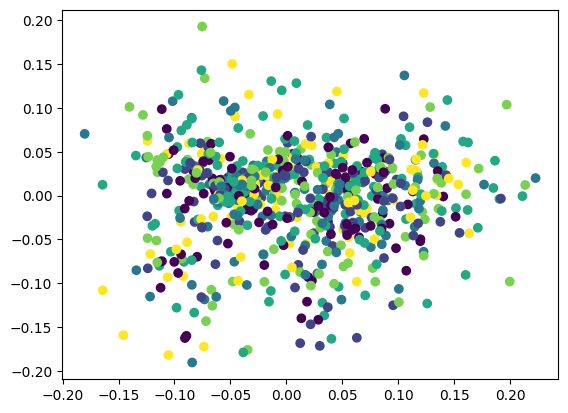

In [11]:
# Run PCA on latent
pca = PCA(n_components=30)
pca = pca.fit(latent)
latent_pca = pca.transform(latent)

fig, ax = plt.subplots()
ax.scatter(latent_pca[:, 2], latent_pca[:, 3], c = y_data.cpu())
plt.show()

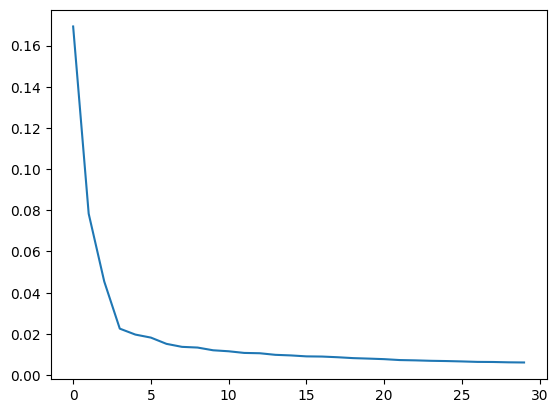

In [12]:
# Explained variance plot
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_)
plt.show()

In [14]:
np.unique(y_data)

array([0, 1, 2, 3, 4, 5])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_features = 6

model = nn.Sequential(
    encoder,
    Flatten(),
    nn.Linear(in_features = 3 * 512 * 4, out_features = 512 * 4, bias=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.ReLU(),
    nn.BatchNorm1d(512 * 4),
    nn.Linear(512 * 4, out_features, bias=True) 
)

model = model.to(device)
model = model.train()

# Lock encoder parameters from training
# for param in model[0].parameters():
#     param.requires_grad = False

In [76]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_data, y_data)

batch_size = 4
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 0.00001
n_epochs = 3

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader), pct_start=0.1, last_epoch=-1
)

In [77]:
for epoch in range(1, n_epochs + 1):
    total = correct = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}, train")
    for batch in train_loader:
        if len(batch[0]) < 2: continue            
        
        optimizer.zero_grad()
                
        X, y = batch
        X, y = X.to(device), y.to(device)
        logits = model(X)        
        _, predicted = torch.max(logits.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        
        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()
        scheduler.step()
        
        pbar.update(1)
        
    pbar.set_description(f"Epoch {epoch}, train accuracy: {100 * correct / total:2f}%")   

Epoch 2, train accuracy: 25.301205%: 100%|██████████| 166/166 [00:02<00:00, 72.44it/s]


In [78]:
with torch.no_grad():
    model.eval()
    total = correct = 0
    pbar = tqdm(total=len(test_loader), desc=f"Testing...")
    for batch in test_loader:
        if len(batch[0]) < 2: continue            
        
        optimizer.zero_grad()
                
        X, y = batch
        X, y = X.to(device), y.to(device)

        logits = model(X)        
        _, predicted = torch.max(logits.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        pbar.update(1)
        
    pbar.set_description(f"Test accuracy: {100 * correct / total:2f}%")

Test accuracy: 35.329341%: 100%|██████████| 42/42 [00:00<00:00, 103.52it/s]

In [79]:
latent = np.empty((X_BC.shape[0], 1536, 4))
batch_size = 4

for i in tqdm(range(0, X_BC.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_BC[i:i+batch_size].to(device)).cpu().detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

100%|██████████| 208/208 [00:00<00:00, 231.30it/s]


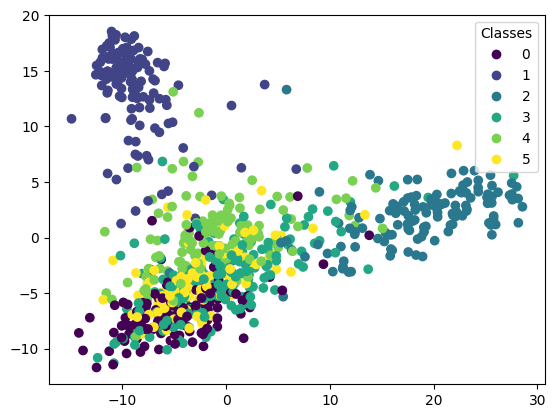

Test accuracy: 35.329341%: 100%|██████████| 42/42 [00:19<00:00, 103.52it/s]

In [80]:
# Run PCA on latent
braincapture_annotations = {'Eye blinking': 0, 'Eye movement left-right': 1, 'Eyes closed': 2, 'Eyes opened': 3, 'Jaw clenching': 4, 'Hyperventilation': 5}

pca = PCA(n_components=30)
pca = pca.fit(latent)
latent_pca = pca.transform(latent)

fig, ax = plt.subplots()
plot = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], c = y_BC)
# Legend according to color c = y_BC
ax.legend(*plot.legend_elements(), title="Classes")


plt.show()